# **What about the minimum dataset for obtaining a satisfying fidelity?**

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [3]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation


In [4]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [5]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [6]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [7]:
sim_bknd=Aer.get_backend('aer_simulator')

In [8]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## (In)Fidelity Implementation

In [9]:
def density_matrix_from_bloch_vector(bloch_vector):
   rho = 0.5 * (I+ bloch_vector[0]*X + bloch_vector[1]*Y + bloch_vector[2]*Z)
   return rho

In [13]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

In [14]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [15]:
A = tf.stack([X_tf,Y_tf,Z_tf]) 

In [79]:
@tf.function
def infidelity1(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   infidelity = 1 - fidelity
   return infidelity 

## Noise Models 


In [19]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [20]:
#BIT FLIP, PHASE FLIP AND BIT-PHASE FLIP ERROR

def flip_error(num_qubits, rho, error_type, p):

    E_0 = np.sqrt(1-p)*I
    if error_type == 'bit':
        E_1 = np.sqrt(p)*X
    if error_type == 'phase':
        E_1 = np.sqrt(p)*Z
    if error_type == 'bp':
        E_1 = np.sqrt(p)*Y
        
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Training the Algorithm

## <font color='red'>MSE - 10 samples</font>

In [41]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:10], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:10], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [42]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [43]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

In [44]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.3334 - val_loss: 0.3236
Epoch 2/200
1/1 [==============================] - 0s 78ms/step - loss: 0.3216 - val_loss: 0.3127
Epoch 3/200
1/1 [==============================] - 0s 81ms/step - loss: 0.3102 - val_loss: 0.3020
Epoch 4/200
1/1 [==============================] - 0s 77ms/step - loss: 0.2991 - val_loss: 0.2917
Epoch 5/200
1/1 [==============================] - 0s 93ms/step - loss: 0.2883 - val_loss: 0.2816
Epoch 6/200
1/1 [==============================] - 0s 82ms/step - loss: 0.2779 - val_loss: 0.2718
Epoch 7/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2679 - val_loss: 0.2623
Epoch 8/200
1/1 [==============================] - 0s 76ms/step - loss: 0.2581 - val_loss: 0.2531
Epoch 9/200
1/1 [==============================] - 0s 88ms/step - loss: 0.2485 - val_loss: 0.2440
Epoch 10/200
1/1 [==============================] - 0s 75ms/step - loss: 0.2392 - val_loss: 0.2352
Epoch 11/200
1/1 [===

1/1 [==============================] - 0s 79ms/step - loss: 7.9230e-04 - val_loss: 0.0089
Epoch 84/200
1/1 [==============================] - 0s 86ms/step - loss: 7.3852e-04 - val_loss: 0.0089
Epoch 85/200
1/1 [==============================] - 0s 87ms/step - loss: 6.9388e-04 - val_loss: 0.0089
Epoch 86/200
1/1 [==============================] - 0s 71ms/step - loss: 6.5630e-04 - val_loss: 0.0089
Epoch 87/200
1/1 [==============================] - 0s 74ms/step - loss: 6.2458e-04 - val_loss: 0.0089
Epoch 88/200
1/1 [==============================] - 0s 92ms/step - loss: 5.9695e-04 - val_loss: 0.0088
Epoch 89/200
1/1 [==============================] - 0s 90ms/step - loss: 5.7308e-04 - val_loss: 0.0088
Epoch 90/200
1/1 [==============================] - 0s 87ms/step - loss: 5.5155e-04 - val_loss: 0.0088
Epoch 91/200
1/1 [==============================] - 0s 89ms/step - loss: 5.3232e-04 - val_loss: 0.0087
Epoch 92/200
1/1 [==============================] - 0s 89ms/step - loss: 5.1453e-04 - 

1/1 [==============================] - 0s 72ms/step - loss: 4.7663e-05 - val_loss: 0.0063
Epoch 163/200
1/1 [==============================] - 0s 86ms/step - loss: 4.6324e-05 - val_loss: 0.0063
Epoch 164/200
1/1 [==============================] - 0s 71ms/step - loss: 4.5022e-05 - val_loss: 0.0063
Epoch 165/200
1/1 [==============================] - 0s 74ms/step - loss: 4.3747e-05 - val_loss: 0.0063
Epoch 166/200
1/1 [==============================] - 0s 70ms/step - loss: 4.2501e-05 - val_loss: 0.0063
Epoch 167/200
1/1 [==============================] - 0s 70ms/step - loss: 4.1288e-05 - val_loss: 0.0063
Epoch 168/200
1/1 [==============================] - 0s 66ms/step - loss: 4.0121e-05 - val_loss: 0.0063
Epoch 169/200
1/1 [==============================] - 0s 69ms/step - loss: 3.8989e-05 - val_loss: 0.0063
Epoch 170/200
1/1 [==============================] - 0s 69ms/step - loss: 3.7865e-05 - val_loss: 0.0062
Epoch 171/200
1/1 [==============================] - 0s 68ms/step - loss: 3.67

In [45]:
score = model.evaluate(x_test,  y_test, verbose=2)

2/2 - 0s - loss: 0.0063 - 190ms/epoch - 95ms/step


In [46]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)


fid10_c = tf.math.reduce_mean(fidelities)
fid10 = tf.cast(fid10_c, tf.float64)
print(fid10)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.9652311619491705, shape=(), dtype=float64)


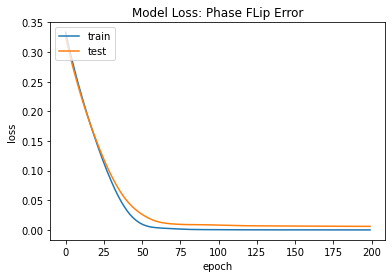

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 5 samples</font>

In [48]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:5], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:5], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [49]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [50]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

In [51]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3528 - val_loss: 0.3285
Epoch 2/200
1/1 [==============================] - 0s 105ms/step - loss: 0.3369 - val_loss: 0.3203
Epoch 3/200
1/1 [==============================] - 0s 91ms/step - loss: 0.3218 - val_loss: 0.3124
Epoch 4/200
1/1 [==============================] - 0s 75ms/step - loss: 0.3072 - val_loss: 0.3047
Epoch 5/200
1/1 [==============================] - 0s 85ms/step - loss: 0.2930 - val_loss: 0.2973
Epoch 6/200
1/1 [==============================] - 0s 86ms/step - loss: 0.2793 - val_loss: 0.2901
Epoch 7/200
1/1 [==============================] - 0s 79ms/step - loss: 0.2662 - val_loss: 0.2831
Epoch 8/200
1/1 [==============================] - 0s 92ms/step - loss: 0.2536 - val_loss: 0.2764
Epoch 9/200
1/1 [==============================] - 0s 78ms/step - loss: 0.2411 - val_loss: 0.2700
Epoch 10/200
1/1 [==============================] - 0s 74ms/step - loss: 0.2290 - val_loss: 0.2639
Epoch 11/200
1/1 [==

1/1 [==============================] - 0s 79ms/step - loss: 1.0573e-04 - val_loss: 0.1005
Epoch 84/200
1/1 [==============================] - 0s 75ms/step - loss: 1.0144e-04 - val_loss: 0.1002
Epoch 85/200
1/1 [==============================] - 0s 87ms/step - loss: 9.7314e-05 - val_loss: 0.1000
Epoch 86/200
1/1 [==============================] - 0s 78ms/step - loss: 9.2958e-05 - val_loss: 0.0998
Epoch 87/200
1/1 [==============================] - 0s 75ms/step - loss: 8.8231e-05 - val_loss: 0.0995
Epoch 88/200
1/1 [==============================] - 0s 77ms/step - loss: 8.3094e-05 - val_loss: 0.0993
Epoch 89/200
1/1 [==============================] - 0s 76ms/step - loss: 7.7589e-05 - val_loss: 0.0991
Epoch 90/200
1/1 [==============================] - 0s 76ms/step - loss: 7.1832e-05 - val_loss: 0.0990
Epoch 91/200
1/1 [==============================] - 0s 75ms/step - loss: 6.5980e-05 - val_loss: 0.0988
Epoch 92/200
1/1 [==============================] - 0s 82ms/step - loss: 6.0207e-05 - 

1/1 [==============================] - 0s 87ms/step - loss: 2.1309e-08 - val_loss: 0.0996
Epoch 163/200
1/1 [==============================] - 0s 76ms/step - loss: 2.0830e-08 - val_loss: 0.0996
Epoch 164/200
1/1 [==============================] - 0s 85ms/step - loss: 2.0462e-08 - val_loss: 0.0996
Epoch 165/200
1/1 [==============================] - 0s 77ms/step - loss: 1.9990e-08 - val_loss: 0.0996
Epoch 166/200
1/1 [==============================] - 0s 80ms/step - loss: 1.9348e-08 - val_loss: 0.0996
Epoch 167/200
1/1 [==============================] - 0s 100ms/step - loss: 1.8545e-08 - val_loss: 0.0996
Epoch 168/200
1/1 [==============================] - 0s 84ms/step - loss: 1.7643e-08 - val_loss: 0.0996
Epoch 169/200
1/1 [==============================] - 0s 84ms/step - loss: 1.6719e-08 - val_loss: 0.0996
Epoch 170/200
1/1 [==============================] - 0s 88ms/step - loss: 1.5878e-08 - val_loss: 0.0996
Epoch 171/200
1/1 [==============================] - 0s 77ms/step - loss: 1.5

In [52]:
score = model.evaluate(x_test,  y_test, verbose=2)

2/2 - 0s - loss: 0.0792 - 180ms/epoch - 90ms/step


In [53]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

fid5_c = tf.math.reduce_mean(fidelities)
fid5 = tf.cast(fid5_c, tf.float64)

print(fid5)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.8635807887409939, shape=(), dtype=float64)


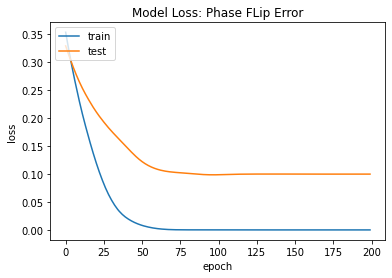

In [54]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 20 samples</font>

In [55]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:20], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:20], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [56]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [57]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

In [58]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 257ms/step - loss: 0.3332 - val_loss: 0.3267
Epoch 2/200
2/2 [==============================] - 0s 85ms/step - loss: 0.3114 - val_loss: 0.3076
Epoch 3/200
2/2 [==============================] - 0s 83ms/step - loss: 0.2929 - val_loss: 0.2896
Epoch 4/200
2/2 [==============================] - 0s 74ms/step - loss: 0.2749 - val_loss: 0.2724
Epoch 5/200
2/2 [==============================] - 0s 83ms/step - loss: 0.2576 - val_loss: 0.2563
Epoch 6/200
2/2 [==============================] - 0s 70ms/step - loss: 0.2423 - val_loss: 0.2406
Epoch 7/200
2/2 [==============================] - 0s 88ms/step - loss: 0.2271 - val_loss: 0.2257
Epoch 8/200
2/2 [==============================] - 0s 79ms/step - loss: 0.2128 - val_loss: 0.2114
Epoch 9/200
2/2 [==============================] - 0s 76ms/step - loss: 0.1990 - val_loss: 0.1974
Epoch 10/200
2/2 [==============================] - 0s 85ms/step - loss: 0.1856 - val_loss: 0.1839
Epoch 11/200
2/2 [

2/2 [==============================] - 0s 75ms/step - loss: 1.2885e-04 - val_loss: 0.0011
Epoch 83/200
2/2 [==============================] - 0s 66ms/step - loss: 1.2420e-04 - val_loss: 0.0011
Epoch 84/200
2/2 [==============================] - 0s 71ms/step - loss: 1.1828e-04 - val_loss: 0.0011
Epoch 85/200
2/2 [==============================] - 0s 70ms/step - loss: 1.1539e-04 - val_loss: 0.0011
Epoch 86/200
2/2 [==============================] - 0s 80ms/step - loss: 1.1110e-04 - val_loss: 0.0011
Epoch 87/200
2/2 [==============================] - 0s 79ms/step - loss: 1.0733e-04 - val_loss: 0.0011
Epoch 88/200
2/2 [==============================] - 0s 91ms/step - loss: 1.0285e-04 - val_loss: 0.0011
Epoch 89/200
2/2 [==============================] - 0s 82ms/step - loss: 9.9288e-05 - val_loss: 0.0011
Epoch 90/200
2/2 [==============================] - 0s 78ms/step - loss: 9.6089e-05 - val_loss: 0.0011
Epoch 91/200
2/2 [==============================] - 0s 71ms/step - loss: 9.3457e-05 - 

2/2 [==============================] - 0s 71ms/step - loss: 1.7733e-05 - val_loss: 9.2326e-04
Epoch 160/200
2/2 [==============================] - 0s 68ms/step - loss: 1.7527e-05 - val_loss: 9.2182e-04
Epoch 161/200
2/2 [==============================] - 0s 65ms/step - loss: 1.7041e-05 - val_loss: 9.2337e-04
Epoch 162/200
2/2 [==============================] - 0s 69ms/step - loss: 1.6682e-05 - val_loss: 9.2278e-04
Epoch 163/200
2/2 [==============================] - 0s 69ms/step - loss: 1.6714e-05 - val_loss: 9.2428e-04
Epoch 164/200
2/2 [==============================] - 0s 74ms/step - loss: 1.6369e-05 - val_loss: 9.2239e-04
Epoch 165/200
2/2 [==============================] - 0s 71ms/step - loss: 1.5858e-05 - val_loss: 9.1780e-04
Epoch 166/200
2/2 [==============================] - 0s 76ms/step - loss: 1.5457e-05 - val_loss: 9.1496e-04
Epoch 167/200
2/2 [==============================] - 0s 79ms/step - loss: 1.5333e-05 - val_loss: 9.1426e-04
Epoch 168/200
2/2 [=======================

In [59]:
score = model.evaluate(x_test,  y_test, verbose=2)

2/2 - 0s - loss: 8.7341e-04 - 182ms/epoch - 91ms/step


In [60]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

fid20_c = tf.math.reduce_mean(fidelities)
fid20 = tf.cast(fid20_c, tf.float64)

print(fid20)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.992972724274007, shape=(), dtype=float64)


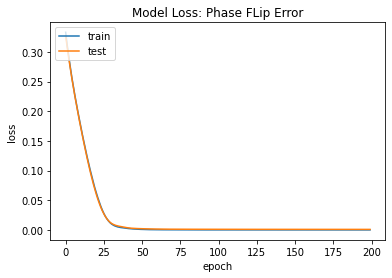

In [61]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 30 samples</font>

In [62]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:30], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:30], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [63]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [64]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

In [65]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 147ms/step - loss: 0.2985 - val_loss: 0.2768
Epoch 2/200
3/3 [==============================] - 0s 38ms/step - loss: 0.2709 - val_loss: 0.2536
Epoch 3/200
3/3 [==============================] - 0s 52ms/step - loss: 0.2476 - val_loss: 0.2321
Epoch 4/200
3/3 [==============================] - 0s 38ms/step - loss: 0.2250 - val_loss: 0.2115
Epoch 5/200
3/3 [==============================] - 0s 41ms/step - loss: 0.2041 - val_loss: 0.1917
Epoch 6/200
3/3 [==============================] - 0s 56ms/step - loss: 0.1846 - val_loss: 0.1726
Epoch 7/200
3/3 [==============================] - 0s 41ms/step - loss: 0.1658 - val_loss: 0.1540
Epoch 8/200
3/3 [==============================] - 0s 38ms/step - loss: 0.1474 - val_loss: 0.1361
Epoch 9/200
3/3 [==============================] - 0s 42ms/step - loss: 0.1300 - val_loss: 0.1189
Epoch 10/200
3/3 [==============================] - 0s 35ms/step - loss: 0.1137 - val_loss: 0.1030
Epoch 11/200
3/3 [

Epoch 82/200
3/3 [==============================] - 0s 34ms/step - loss: 1.7575e-04 - val_loss: 0.0016
Epoch 83/200
3/3 [==============================] - 0s 36ms/step - loss: 1.7362e-04 - val_loss: 0.0016
Epoch 84/200
3/3 [==============================] - 0s 38ms/step - loss: 1.6851e-04 - val_loss: 0.0015
Epoch 85/200
3/3 [==============================] - 0s 42ms/step - loss: 1.6501e-04 - val_loss: 0.0015
Epoch 86/200
3/3 [==============================] - 0s 38ms/step - loss: 1.6458e-04 - val_loss: 0.0015
Epoch 87/200
3/3 [==============================] - 0s 37ms/step - loss: 1.5972e-04 - val_loss: 0.0015
Epoch 88/200
3/3 [==============================] - 0s 37ms/step - loss: 1.5629e-04 - val_loss: 0.0015
Epoch 89/200
3/3 [==============================] - 0s 35ms/step - loss: 1.5661e-04 - val_loss: 0.0015
Epoch 90/200
3/3 [==============================] - 0s 39ms/step - loss: 1.5346e-04 - val_loss: 0.0015
Epoch 91/200
3/3 [==============================] - 0s 38ms/step - loss: 

Epoch 161/200
3/3 [==============================] - 0s 40ms/step - loss: 4.9410e-05 - val_loss: 0.0010
Epoch 162/200
3/3 [==============================] - 0s 34ms/step - loss: 4.5438e-05 - val_loss: 0.0010
Epoch 163/200
3/3 [==============================] - 0s 35ms/step - loss: 4.4908e-05 - val_loss: 0.0010
Epoch 164/200
3/3 [==============================] - 0s 37ms/step - loss: 4.5465e-05 - val_loss: 0.0010
Epoch 165/200
3/3 [==============================] - 0s 35ms/step - loss: 4.3635e-05 - val_loss: 0.0010
Epoch 166/200
3/3 [==============================] - 0s 40ms/step - loss: 4.1431e-05 - val_loss: 0.0010
Epoch 167/200
3/3 [==============================] - 0s 42ms/step - loss: 4.1608e-05 - val_loss: 0.0010
Epoch 168/200
3/3 [==============================] - 0s 47ms/step - loss: 4.0725e-05 - val_loss: 9.9309e-04
Epoch 169/200
3/3 [==============================] - 0s 38ms/step - loss: 3.9459e-05 - val_loss: 9.8625e-04
Epoch 170/200
3/3 [==============================] - 0s 

In [66]:
score = model.evaluate(x_test,  y_test, verbose=2)

2/2 - 0s - loss: 6.4674e-04 - 213ms/epoch - 107ms/step


In [69]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

fid30_c = tf.math.reduce_mean(fidelities)
fid30 = tf.cast(fid30_c, tf.float64)
print(fid30)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.9969219402806422, shape=(), dtype=float64)


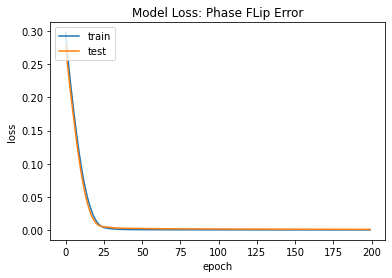

In [68]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>INF - 10 samples</font>

In [70]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:10], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:10], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [80]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [81]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity1)

In [82]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.4821 - val_loss: 0.3514
Epoch 2/200
1/1 [==============================] - 0s 74ms/step - loss: 0.3514 - val_loss: 0.2959
Epoch 3/200
1/1 [==============================] - 0s 76ms/step - loss: 0.2880 - val_loss: 0.2511
Epoch 4/200
1/1 [==============================] - 0s 80ms/step - loss: 0.2350 - val_loss: 0.2100
Epoch 5/200
1/1 [==============================] - 0s 77ms/step - loss: 0.1894 - val_loss: 0.1701
Epoch 6/200
1/1 [==============================] - 0s 77ms/step - loss: 0.1495 - val_loss: 0.1389
Epoch 7/200
1/1 [==============================] - 0s 70ms/step - loss: 0.1166 - val_loss: 0.1175
Epoch 8/200
1/1 [==============================] - 0s 118ms/step - loss: 0.0910 - val_loss: 0.1031
Epoch 9/200
1/1 [==============================] - 0s 98ms/step - loss: 0.0721 - val_loss: 0.0933
Epoch 10/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0578 - val_loss: 0.0866
Epoch 11/200
1/1 [==

Epoch 83/200
1/1 [==============================] - 0s 71ms/step - loss: 2.4460e-04 - val_loss: 0.0237
Epoch 84/200
1/1 [==============================] - 0s 69ms/step - loss: 2.3081e-04 - val_loss: 0.0236
Epoch 85/200
1/1 [==============================] - 0s 74ms/step - loss: 2.1773e-04 - val_loss: 0.0235
Epoch 86/200
1/1 [==============================] - 0s 75ms/step - loss: 2.0539e-04 - val_loss: 0.0233
Epoch 87/200
1/1 [==============================] - 0s 75ms/step - loss: 1.9372e-04 - val_loss: 0.0232
Epoch 88/200
1/1 [==============================] - 0s 68ms/step - loss: 1.8263e-04 - val_loss: 0.0231
Epoch 89/200
1/1 [==============================] - 0s 75ms/step - loss: 1.7216e-04 - val_loss: 0.0230
Epoch 90/200
1/1 [==============================] - 0s 73ms/step - loss: 1.6224e-04 - val_loss: 0.0229
Epoch 91/200
1/1 [==============================] - 0s 70ms/step - loss: 1.5275e-04 - val_loss: 0.0228
Epoch 92/200
1/1 [==============================] - 0s 73ms/step - loss: 

Epoch 162/200
1/1 [==============================] - 0s 92ms/step - loss: 1.4424e-06 - val_loss: 0.0196
Epoch 163/200
1/1 [==============================] - 0s 91ms/step - loss: 1.3292e-06 - val_loss: 0.0196
Epoch 164/200
1/1 [==============================] - 0s 88ms/step - loss: 1.2577e-06 - val_loss: 0.0196
Epoch 165/200
1/1 [==============================] - 0s 78ms/step - loss: 1.1742e-06 - val_loss: 0.0196
Epoch 166/200
1/1 [==============================] - 0s 71ms/step - loss: 1.0908e-06 - val_loss: 0.0195
Epoch 167/200
1/1 [==============================] - 0s 75ms/step - loss: 1.0252e-06 - val_loss: 0.0195
Epoch 168/200
1/1 [==============================] - 0s 70ms/step - loss: 9.5367e-07 - val_loss: 0.0195
Epoch 169/200
1/1 [==============================] - 0s 82ms/step - loss: 9.0003e-07 - val_loss: 0.0195
Epoch 170/200
1/1 [==============================] - 0s 95ms/step - loss: 8.5235e-07 - val_loss: 0.0195
Epoch 171/200
1/1 [==============================] - 0s 75ms/ste

In [83]:
score = model.evaluate(x_test,  y_test, verbose=2)

2/2 - 0s - loss: 0.0077 - 395ms/epoch - 198ms/step


In [84]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

inf10_c = tf.math.reduce_mean(fidelities)
inf10 = tf.cast(inf10_c, tf.float64)
print(inf10)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.9922894383222044, shape=(), dtype=float64)


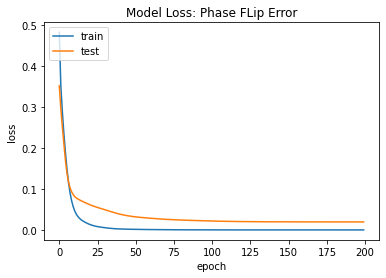

In [85]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>INF - 5 samples</font>

In [86]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:5], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:5], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [87]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [90]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity1)

In [91]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.5034 - val_loss: 0.3652
Epoch 2/200
1/1 [==============================] - 0s 87ms/step - loss: 0.4627 - val_loss: 0.3486
Epoch 3/200
1/1 [==============================] - 0s 96ms/step - loss: 0.4237 - val_loss: 0.3320
Epoch 4/200
1/1 [==============================] - 0s 81ms/step - loss: 0.3886 - val_loss: 0.3155
Epoch 5/200
1/1 [==============================] - 0s 84ms/step - loss: 0.3565 - val_loss: 0.2987
Epoch 6/200
1/1 [==============================] - 0s 77ms/step - loss: 0.3274 - val_loss: 0.2822
Epoch 7/200
1/1 [==============================] - 0s 92ms/step - loss: 0.3013 - val_loss: 0.2663
Epoch 8/200
1/1 [==============================] - 0s 83ms/step - loss: 0.2775 - val_loss: 0.2511
Epoch 9/200
1/1 [==============================] - 0s 89ms/step - loss: 0.2553 - val_loss: 0.2365
Epoch 10/200
1/1 [==============================] - 0s 78ms/step - loss: 0.2341 - val_loss: 0.2220
Epoch 11/200
1/1 [===

Epoch 83/200
1/1 [==============================] - 0s 73ms/step - loss: 2.0528e-05 - val_loss: 0.0479
Epoch 84/200
1/1 [==============================] - 0s 76ms/step - loss: 1.7941e-05 - val_loss: 0.0481
Epoch 85/200
1/1 [==============================] - 0s 80ms/step - loss: 1.6844e-05 - val_loss: 0.0481
Epoch 86/200
1/1 [==============================] - 0s 68ms/step - loss: 1.6713e-05 - val_loss: 0.0482
Epoch 87/200
1/1 [==============================] - 0s 72ms/step - loss: 1.7190e-05 - val_loss: 0.0483
Epoch 88/200
1/1 [==============================] - 0s 72ms/step - loss: 1.7822e-05 - val_loss: 0.0483
Epoch 89/200
1/1 [==============================] - 0s 70ms/step - loss: 1.8322e-05 - val_loss: 0.0483
Epoch 90/200
1/1 [==============================] - 0s 79ms/step - loss: 1.8597e-05 - val_loss: 0.0482
Epoch 91/200
1/1 [==============================] - 0s 76ms/step - loss: 1.8442e-05 - val_loss: 0.0482
Epoch 92/200
1/1 [==============================] - 0s 71ms/step - loss: 

Epoch 162/200
1/1 [==============================] - 0s 75ms/step - loss: 2.3842e-08 - val_loss: 0.0484
Epoch 163/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0000e+00 - val_loss: 0.0484
Epoch 164/200
1/1 [==============================] - 0s 73ms/step - loss: 2.3842e-08 - val_loss: 0.0484
Epoch 165/200
1/1 [==============================] - 0s 71ms/step - loss: 1.1921e-08 - val_loss: 0.0484
Epoch 166/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0000e+00 - val_loss: 0.0484
Epoch 167/200
1/1 [==============================] - 0s 72ms/step - loss: 1.1921e-08 - val_loss: 0.0484
Epoch 168/200
1/1 [==============================] - 0s 72ms/step - loss: 3.5763e-08 - val_loss: 0.0484
Epoch 169/200
1/1 [==============================] - 0s 71ms/step - loss: 2.3842e-08 - val_loss: 0.0484
Epoch 170/200
1/1 [==============================] - 0s 105ms/step - loss: 4.7684e-08 - val_loss: 0.0484
Epoch 171/200
1/1 [==============================] - 0s 82ms/st

In [92]:
score = model.evaluate(x_test,  y_test, verbose=2)

2/2 - 0s - loss: 0.0384 - 239ms/epoch - 119ms/step


In [95]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)


inf5_c = tf.math.reduce_mean(fidelities)
inf5 = tf.cast(inf5_c, tf.float64)
print(inf5)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.9615528298643407, shape=(), dtype=float64)


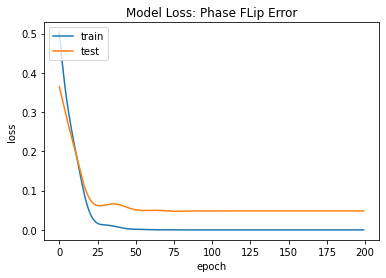

In [96]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>INF - 20 samples</font>

In [97]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:20], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:20], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [98]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [99]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity1)

In [100]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
2/2 [==============================] - 2s 291ms/step - loss: 0.4590 - val_loss: 0.3777
Epoch 2/200
2/2 [==============================] - 0s 90ms/step - loss: 0.3356 - val_loss: 0.2987
Epoch 3/200
2/2 [==============================] - 0s 89ms/step - loss: 0.2684 - val_loss: 0.2176
Epoch 4/200
2/2 [==============================] - 0s 73ms/step - loss: 0.2023 - val_loss: 0.1542
Epoch 5/200
2/2 [==============================] - 0s 79ms/step - loss: 0.1523 - val_loss: 0.1086
Epoch 6/200
2/2 [==============================] - 0s 75ms/step - loss: 0.1156 - val_loss: 0.0754
Epoch 7/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0869 - val_loss: 0.0539
Epoch 8/200
2/2 [==============================] - 0s 78ms/step - loss: 0.0678 - val_loss: 0.0406
Epoch 9/200
2/2 [==============================] - 0s 92ms/step - loss: 0.0501 - val_loss: 0.0332
Epoch 10/200
2/2 [==============================] - 0s 67ms/step - loss: 0.0409 - val_loss: 0.0290
Epoch 11/200
2/2 [

Epoch 82/200
2/2 [==============================] - 0s 90ms/step - loss: 2.8744e-05 - val_loss: 0.0028
Epoch 83/200
2/2 [==============================] - 0s 69ms/step - loss: 2.6733e-05 - val_loss: 0.0028
Epoch 84/200
2/2 [==============================] - 0s 70ms/step - loss: 2.5445e-05 - val_loss: 0.0028
Epoch 85/200
2/2 [==============================] - 0s 70ms/step - loss: 2.4220e-05 - val_loss: 0.0028
Epoch 86/200
2/2 [==============================] - 0s 81ms/step - loss: 2.2396e-05 - val_loss: 0.0028
Epoch 87/200
2/2 [==============================] - 0s 78ms/step - loss: 2.1413e-05 - val_loss: 0.0028
Epoch 88/200
2/2 [==============================] - 0s 68ms/step - loss: 1.9783e-05 - val_loss: 0.0028
Epoch 89/200
2/2 [==============================] - 0s 71ms/step - loss: 1.8641e-05 - val_loss: 0.0027
Epoch 90/200
2/2 [==============================] - 0s 68ms/step - loss: 1.7869e-05 - val_loss: 0.0027
Epoch 91/200
2/2 [==============================] - 0s 67ms/step - loss: 

Epoch 161/200
2/2 [==============================] - 0s 80ms/step - loss: 1.2904e-06 - val_loss: 0.0026
Epoch 162/200
2/2 [==============================] - 0s 86ms/step - loss: 1.2457e-06 - val_loss: 0.0026
Epoch 163/200
2/2 [==============================] - 0s 79ms/step - loss: 1.2070e-06 - val_loss: 0.0026
Epoch 164/200
2/2 [==============================] - 0s 70ms/step - loss: 1.1832e-06 - val_loss: 0.0026
Epoch 165/200
2/2 [==============================] - 0s 69ms/step - loss: 1.1444e-06 - val_loss: 0.0026
Epoch 166/200
2/2 [==============================] - 0s 78ms/step - loss: 1.0937e-06 - val_loss: 0.0026
Epoch 167/200
2/2 [==============================] - 0s 72ms/step - loss: 1.0818e-06 - val_loss: 0.0026
Epoch 168/200
2/2 [==============================] - 0s 71ms/step - loss: 1.0997e-06 - val_loss: 0.0026
Epoch 169/200
2/2 [==============================] - 0s 71ms/step - loss: 1.0610e-06 - val_loss: 0.0026
Epoch 170/200
2/2 [==============================] - 0s 67ms/ste

In [101]:
score = model.evaluate(x_test,  y_test, verbose=2)

2/2 - 0s - loss: 0.0015 - 241ms/epoch - 120ms/step


In [102]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)


inf20_c = tf.math.reduce_mean(fidelities)
inf20 = tf.cast(inf20_c, tf.float64)
print(inf20)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.9984537160932214, shape=(), dtype=float64)


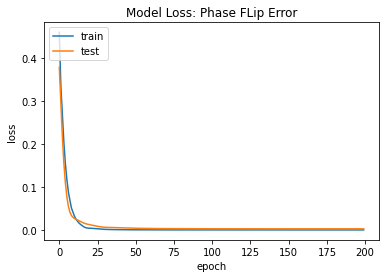

In [103]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>INF - 30 samples</font>

In [104]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:30], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:30], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [105]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [107]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity1)

In [108]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 148ms/step - loss: 0.5305 - val_loss: 0.3577
Epoch 2/200
3/3 [==============================] - 0s 38ms/step - loss: 0.4249 - val_loss: 0.2548
Epoch 3/200
3/3 [==============================] - 0s 41ms/step - loss: 0.3322 - val_loss: 0.2072
Epoch 4/200
3/3 [==============================] - 0s 45ms/step - loss: 0.2390 - val_loss: 0.1623
Epoch 5/200
3/3 [==============================] - 0s 43ms/step - loss: 0.1367 - val_loss: 0.1016
Epoch 6/200
3/3 [==============================] - 0s 44ms/step - loss: 0.0632 - val_loss: 0.0579
Epoch 7/200
3/3 [==============================] - 0s 42ms/step - loss: 0.0314 - val_loss: 0.0339
Epoch 8/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0175 - val_loss: 0.0202
Epoch 9/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0116 - val_loss: 0.0142
Epoch 10/200
3/3 [==============================] - 0s 42ms/step - loss: 0.0094 - val_loss: 0.0120
Epoch 11/200
3/3 [

3/3 [==============================] - 0s 37ms/step - loss: 8.0224e-05 - val_loss: 9.5451e-04
Epoch 82/200
3/3 [==============================] - 0s 41ms/step - loss: 7.6358e-05 - val_loss: 9.4882e-04
Epoch 83/200
3/3 [==============================] - 0s 37ms/step - loss: 7.3244e-05 - val_loss: 9.3636e-04
Epoch 84/200
3/3 [==============================] - 0s 42ms/step - loss: 7.0771e-05 - val_loss: 9.2599e-04
Epoch 85/200
3/3 [==============================] - 0s 45ms/step - loss: 6.8136e-05 - val_loss: 9.1488e-04
Epoch 86/200
3/3 [==============================] - 0s 37ms/step - loss: 6.6562e-05 - val_loss: 9.1326e-04
Epoch 87/200
3/3 [==============================] - 0s 38ms/step - loss: 6.3813e-05 - val_loss: 9.1379e-04
Epoch 88/200
3/3 [==============================] - 0s 40ms/step - loss: 6.2205e-05 - val_loss: 9.0916e-04
Epoch 89/200
3/3 [==============================] - 0s 34ms/step - loss: 6.0236e-05 - val_loss: 9.0064e-04
Epoch 90/200
3/3 [==============================] 

3/3 [==============================] - 0s 39ms/step - loss: 1.0842e-05 - val_loss: 7.6169e-04
Epoch 158/200
3/3 [==============================] - 0s 51ms/step - loss: 1.0586e-05 - val_loss: 7.6229e-04
Epoch 159/200
3/3 [==============================] - 0s 48ms/step - loss: 1.0512e-05 - val_loss: 7.5585e-04
Epoch 160/200
3/3 [==============================] - 0s 41ms/step - loss: 1.0453e-05 - val_loss: 7.4864e-04
Epoch 161/200
3/3 [==============================] - 0s 33ms/step - loss: 9.9937e-06 - val_loss: 7.5433e-04
Epoch 162/200
3/3 [==============================] - 0s 37ms/step - loss: 9.6977e-06 - val_loss: 7.6016e-04
Epoch 163/200
3/3 [==============================] - 0s 33ms/step - loss: 9.4175e-06 - val_loss: 7.5481e-04
Epoch 164/200
3/3 [==============================] - 0s 35ms/step - loss: 9.1394e-06 - val_loss: 7.5022e-04
Epoch 165/200
3/3 [==============================] - 0s 33ms/step - loss: 9.0023e-06 - val_loss: 7.5121e-04
Epoch 166/200
3/3 [=======================

In [109]:
score = model.evaluate(x_test,  y_test, verbose=2)

2/2 - 0s - loss: 5.9585e-04 - 241ms/epoch - 121ms/step


In [110]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)


inf30_c = tf.math.reduce_mean(fidelities)
inf30 = tf.cast(inf30_c, tf.float64)

print(inf30)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.9994041559531295, shape=(), dtype=float64)


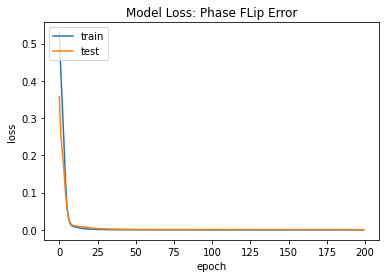

In [111]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='purple'>Plotting the Results</font>

In [112]:
x = np.array([5, 10, 20, 30])
y = np.array([fid5, fid10, fid20, fid30])
z = np.array([inf5, inf10, inf20, inf30])

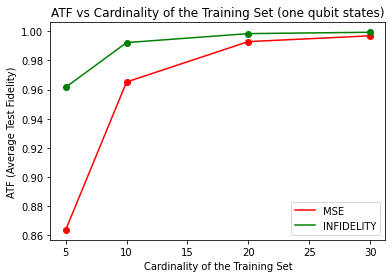

In [113]:
plt.plot(x, y, color='r', label='MSE')
plt.plot(x, z, color='g', label='INFIDELITY')
plt.scatter(x, y, color='r', label='_nolegend_')
plt.scatter(x, z, color='g', label='_nolegend_')

plt.title("ATF vs Cardinality of the Training Set (one qubit states)")
plt.xlabel("Cardinality of the Training Set") 
plt.ylabel("ATF (Average Test Fidelity)")
plt.legend()


plt.savefig("md_oq.png")